# Setup

In [ ]:
# !pip install gdown

In [ ]:
!ls

sample_data


In [ ]:
!gdown --id 1TlNA_FeBdZu0p-NcY8xpEeO23q9d6173

Downloading...
From: https://drive.google.com/uc?id=1TlNA_FeBdZu0p-NcY8xpEeO23q9d6173
To: /content/youtube_comments.zip
58.6MB [00:00, 76.6MB/s]


In [ ]:
# !unzip ../content/youtube_comments.zip -o

In [ ]:
import zipfile
with zipfile.ZipFile("/content/youtube_comments.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
!pip install transformers==2.11.0 -q
!pip install -U sentence-transformers -q
!pip install -q emoji

     |████████████████████████████████| 675kB 2.7MB/s 
     |████████████████████████████████| 890kB 14.4MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
     |████████████████████████████████| 3.8MB 25.0MB/s 
     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 890kB 5.7MB/s 
     |████████████████████████████████| 3.0MB 31.9MB/s 
     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
!pip install -q hdbscan

     |████████████████████████████████| 4.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

embedder = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:44<00:00, 9.17MB/s]


# Exploratory data analysis

### Load data into pandas

In [ ]:
root_path = "/content"
df = pd.read_csv (f'{root_path}/UScomments.csv', error_bad_lines=False)
df.head()

b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [ ]:
df.groupby("video_id").count().idxmax()

comment_text    4X6a3G_0HjY
likes           4X6a3G_0HjY
replies         4X6a3G_0HjY
dtype: object

In [ ]:
df_corpus = df.loc[df['video_id']=="4X6a3G_0HjY"]

### Check to see why bad lines have problems

In [ ]:
!sed -n '41588,41590p' UScomments.csv

_ANP3HR1jsM,"When are we gonna see the Beard Flip??",0,0
_ANP3HR1jsM,"My dad raised Razor's Edge Pitbulls. If you faced any of them Roman, you'd probably die. No offense, but the dogs were trained to where you could take them out anywhere and be fine, but if you were in danger, my dad could say grrr and the dog would growl at whoever my dad pointvideo_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_displayed_here
_ANP3HR1jsM,368_ovPsJk8,"THE SHAPE OF WATER - Red Band Trailer","FoxSearchlight",1,Michael Shannon|Richard Jenkins|Doug Jones|sally hawkins|guillermo del toro|the shape of water|shape of water|fox searchlight|fox movie|fox movies|trailer|new trailer|octavia spencer|hidden figures,496221,7571,521,1215,https://i.ytimg.com/vi/368_ovPsJk8/default.jpg,100


In [ ]:
!sed -n '51627,51629p' UScomments.csv

JO7X9ZPoAp8,"What a sweet video",0,0
JO7X9ZPoAp8,"The girl is cute.",0,0
JO7X9ZPoAp8,"This comment section made me lose faith in humanity.",1,0KFUIVfKTeVg,"Don't worry everyone. It was just the religion of peace! No reason to be alarmed!",11,0


In [ ]:
!sed -n '114464,114466p' UScomments.csv

RLmqKBRqyA8,"NEED",0,0
RLmqKBRqyA8,"https://youtu.be/vNv-B65PjPI",0,0
RLmqKBRqyA8,"Awesome video. Thanks guys!",0,0


In [ ]:
!sed -n '189731,189733p' UScomments.csv

mWFaxs-KvMY,"Song Sick 😍 deserve more views",0,0
mWFaxs-KvMY,"😍💕",0,0
mWFaxs-KvMY,"LOVE THIS SONG! 😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗😻💗💗😻💗😻💗😻💗",0,0


In [ ]:
!sed -n '245217,245219p' UScomments.csv

YYmlI7yT9cg,"GJ",0,0
YYmlI7yT9cg,"Amazing",0,0
YYmlI7yT9cg,"klappspaten",0,0


In [ ]:
print(f'There are {df.video_id.nunique()} unique video IDs')
print(df.video_id.unique())

There are 2266 unique video IDs
['XpVt6Z1Gjjo' 'cLdxuaxaQwc' 'WYYvHb03Eog' ... 'S9VIKOuZcds' 'a5NIg5yyHWo'
 '3VSa-oARk-w']


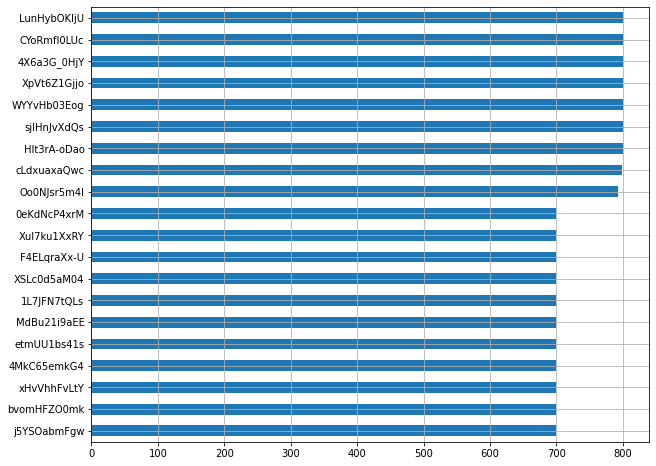

In [ ]:
ax = df.video_id.value_counts().head(20).sort_values().plot.barh(figsize=(10,8), grid=True)

In [ ]:
df.video_id.value_counts().head(20).sort_values(ascending=False)

LunHybOKIjU    800
CYoRmfI0LUc    800
4X6a3G_0HjY    800
XpVt6Z1Gjjo    800
WYYvHb03Eog    800
sjlHnJvXdQs    800
Hlt3rA-oDao    800
cLdxuaxaQwc    799
Oo0NJsr5m4I    793
0eKdNcP4xrM    700
Xul7ku1XxRY    700
F4ELqraXx-U    700
XSLc0d5aM04    700
1L7JFN7tQLs    700
MdBu21i9aEE    700
etmUU1bs41s    700
4MkC65emkG4    700
xHvVhhFvLtY    700
bvomHFZO0mk    700
j5YSOabmFgw    700
Name: video_id, dtype: int64

In [ ]:
# Choose the following Youtube video (Eminem):
# https://www.youtube.com/watch?v=LunHybOKIjU
video_id = 'LunHybOKIjU'
df_corpus = df.loc[df['video_id']==video_id]

In [ ]:
# Count the number of comments, likes, and replies for each video_id
df.groupby("video_id").count()

,comment_text,likes,replies
video_id,,,
--JinobXWPk,100,100,100
-1fzGnFwz9M,100,100,100
-3AGlBYyLjo,4,4,4
-5sCWsLlTCI,67,67,67
-6Zc8Co2H3w,400,400,400
...,...,...,...
zqE-ultsWt0,500,500,500
zrOHeEA14kQ,497,498,498
zuKX0fPlo2Q,2,2,2


### Experiment with cleaning

In [ ]:
df_corpus["comment_text"].head()

484114    I CAN TELL THAT FROM THE POSTS, MOST OF YOU EI...
484115    Hey Eminem! I love your song Kim about murderi...
484116         This cypher is so dope though!! Thanks em!✊🏾
484117    Well that was Wack my Mom rhyms better then Ol...
484118    OOH THE CRINGE!! I hope one day you break your...
Name: comment_text, dtype: object

In [ ]:
import emoji
print(emoji.demojize('trending 😉	'))

trending :winking_face:	


In [ ]:
# De-emojize
df_corpus['comments_cleaned'] = df_corpus['comment_text'].apply(emoji.demojize)

# Replace the colons, and \n with a space
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[\n:]', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace(r'\\n', ' ', regex=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.lower()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# remove duplicate comments
df_corpus.drop_duplicates(subset=['comments_cleaned'], inplace = True)
df_corpus.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(796, 5)

In [ ]:
# remove special characters
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('[^a-zA-Z0-9]', ' ')

# remove white spaces
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.replace('\s+', ' ', regex=True)
df_corpus['comments_cleaned'] = df_corpus['comments_cleaned'].str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
df_corpus['comments_cleaned'].to_csv('meta.tsv', columns=['comments_cleaned'], index= False, header= False)

The longest comment has 2993 characters

In [ ]:
df_corpus['comments_cleaned'].apply(len).sort_values(ascending=False).head(20)

617593    2993
617643    1810
556064    1606
577359    1599
484153    1046
536259    1008
598731     964
518174     955
598730     749
577392     718
501290     683
598746     662
556072     613
536271     598
598732     577
577360     557
484211     552
536313     537
501374     455
556038     455
Name: comments_cleaned, dtype: int64

# Sentence Bert Embeddings

In [ ]:
corpus_embeddings = embedder.encode(df_corpus["comments_cleaned"].values.tolist())

In [ ]:
corpus_embeddings = np.array(corpus_embeddings)
corpus_embeddings.shape

(796, 768)

In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, corpus_embeddings, 90)

# Google Universal Encoder

In [ ]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [ ]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the emtbedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.034585658460855484, -0.01799013279378414, 0.0019805801566690207, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833398923277855, -0.08185011148452759, 0.0689094066619873, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the emtbedding will be.
Embedding size: 512
Embedding: [-0.018883399665355682, -0.003110924270004034, -0.03367334231734276, ...]



# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [ ]:
messages0 = df_corpus["comments_cleaned"].values.tolist()

In [ ]:
df_corpus["comments_cleaned"].apply(len).max()

2993

In [ ]:
embeddings_long = embed([df_corpus['comments_cleaned'].loc[617593]])

In [ ]:
embeddings_long

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.02065621,  0.06701472, -0.08154469, -0.06977336,  0.01890232,
         0.06811433,  0.0007565 , -0.04219255, -0.00199334, -0.05480891,
        -0.02256205,  0.00623562,  0.00959479,  0.0099476 ,  0.02800437,
        -0.01678223,  0.01486157, -0.01758528,  0.00427578,  0.06891661,
         0.00768514,  0.00796505,  0.04401688, -0.0069132 , -0.03816444,
         0.10753623,  0.07232828,  0.0399569 ,  0.05410536,  0.01731798,
        -0.0332901 , -0.02883785, -0.09495936, -0.05368938,  0.01561815,
        -0.06330614,  0.02925803,  0.06432469,  0.01506556, -0.11305193,
         0.02130421, -0.03043011,  0.04507275, -0.01167138, -0.04154443,
        -0.01656689,  0.01475974, -0.06070335,  0.02082287,  0.07529438,
        -0.04364755,  0.02082466, -0.00331862,  0.00148609,  0.03568432,
        -0.03335595,  0.02829643,  0.03887918, -0.10894081, -0.0068591 ,
        -0.05176786, -0.04355756, -0.01046361,  0.03508608, -0.03865952,
 

In [ ]:
max_chars = 2200  # Take only the first 2200 characters of each comment. Crashes at 2300+
messages = df_corpus["comments_cleaned"].apply(
    lambda x: x[:max_chars]
).values.tolist()

In [ ]:
embeddings = embed(messages)
np.savetxt('vecs.tsv', embeddings , delimiter="\t")

In [ ]:
pd.Series(messages).apply(len).max()

2200

In [ ]:
!head -20 vecs.tsv

3.745016083121299744e-02	-5.593793466687202454e-02	-3.151396056637167931e-03	2.978692576289176941e-02	-4.320840910077095032e-02	-2.091149240732192993e-02	-1.474653370678424835e-02	7.144860178232192993e-02	1.113301888108253479e-02	-4.998926073312759399e-02	6.987469643354415894e-02	-1.413240330293774605e-03	-1.180290244519710541e-02	-1.685835234820842743e-02	1.981312595307826996e-02	5.061080679297447205e-02	-1.130120549350976944e-02	-1.244556084275245667e-01	-1.389786694198846817e-02	3.494636341929435730e-02	-6.595582515001296997e-02	-3.879776224493980408e-02	-3.836499527096748352e-02	-5.284486804157495499e-03	-5.202335864305496216e-02	-1.624985225498676300e-02	-5.920656025409698486e-03	-3.329467028379440308e-02	3.452086448669433594e-02	4.178628325462341309e-02	8.337953686714172363e-02	8.610197110101580620e-04	-4.998350981622934341e-03	-9.227620810270309448e-02	-7.062112912535667419e-03	3.996644169092178345e-02	-3.859132528305053711e-02	-1.377943716943264008e-02	1.080619730055332184e-02	

### PCA reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#scale the data 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rescaled = scaler.fit_transform(embeddings)

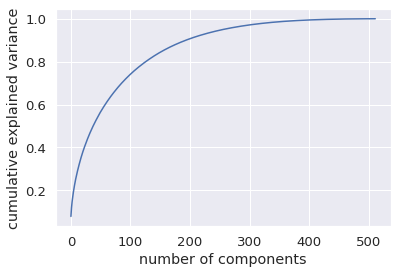

In [ ]:
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
# need around 200 components to describe 100% of variance
pca = PCA(n_components = 50)
reduced_embeds = pca.fit_transform(rescaled)
print("Original shape:   ", rescaled.shape)
print("Transformed shape:", reduced_embeds.shape)

Original shape:    (796, 512)
Transformed shape: (796, 50)


In [ ]:

# pca = PCA(n_components = 50)
# reduced_embeds = pca.fit_transform(rescaled)

In [ ]:
# reduced_embeds.shape

### Run HDBScan to find the clusters

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(reduced_embeds)
clusterer.labels_

array([-1,  5, -1, -1, -1, -1,  4,  5, -1, -1, -1, -1,  5, -1,  5, -1, -1,
       -1, -1,  5, -1, -1, -1,  5, -1, -1, -1,  5, -1, -1,  5, -1, -1, -1,
       -1,  5, -1,  5,  4,  5,  5, -1,  5,  5, -1,  5, -1, -1, -1,  5,  5,
       -1,  5, -1, -1, -1,  5,  5, -1, -1, -1,  5, -1, -1, -1, -1,  5,  3,
       -1, -1,  3, -1, -1,  3,  2, -1, -1, -1,  3, -1,  5, -1, -1, -1, -1,
        3,  3, -1, -1, -1,  4,  3, -1, -1, -1, -1,  5, -1, -1, -1, -1,  5,
        5,  5,  2, -1, -1, -1, -1,  4,  5, -1, -1, -1, -1,  5, -1,  5, -1,
       -1, -1, -1, -1,  5, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1,  5, -1,
        5, -1, -1, -1,  5, -1, -1,  5, -1, -1, -1, -1, -1,  5, -1, -1, -1,
        5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1, -1,  3,
       -1, -1, -1, -1, -1, -1, -1, -1,  3,  5, -1,  3, -1, -1, -1, -1, -1,
       -1, -1, -1,  3, -1, -1, -1, -1, -1, -1,  5, -1, -1, -1, -1,  5, -1,
        5, -1,  5, -1,  5, -1,  5, -1, -1,  5, -1, -1, -1, -1, -1,  5,  5,
       -1, -1, -1,  5, -1

In [ ]:
clusterer.labels_.max()

5

In [ ]:
df_corpus['hdb_labels'] = clusterer.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_corpus.to_csv('meta_lab.tsv', columns=['comments_cleaned','hdb_labels'], index= False, header= True, sep='\t')

In [ ]:
!head -5 meta.tsv

i can tell that from the posts most of you either never took eng grammer or flunked or english is a second language anyway research the history of the democratic party if you can read
hey eminem i love your song kim about murdering a child and killing a woman
this cypher is so dope though thanks em raised fist medium dark skin tone
well that was wack my mom rhyms better then old grandpa here
ooh the cringe i hope one day you break your libtard brainwashing and realise how awful that was


In [ ]:
!head -5 meta_lab.tsv

comments_cleaned	hdb_labels
i can tell that from the posts most of you either never took eng grammer or flunked or english is a second language anyway research the history of the democratic party if you can read	-1
hey eminem i love your song kim about murdering a child and killing a woman	5
this cypher is so dope though thanks em raised fist medium dark skin tone	-1
well that was wack my mom rhyms better then old grandpa here	-1


Save`vecs.tsv` and `meta_lab.tsv` and load them into http://projector.tensorflow.org/ (use `vecs.tsv` for Step 1 and `meta_lab.tsv` for step 2)

In [ ]:
from google.colab import files

files.download('vecs.tsv')
files.download('meta_lab.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting similarity charts


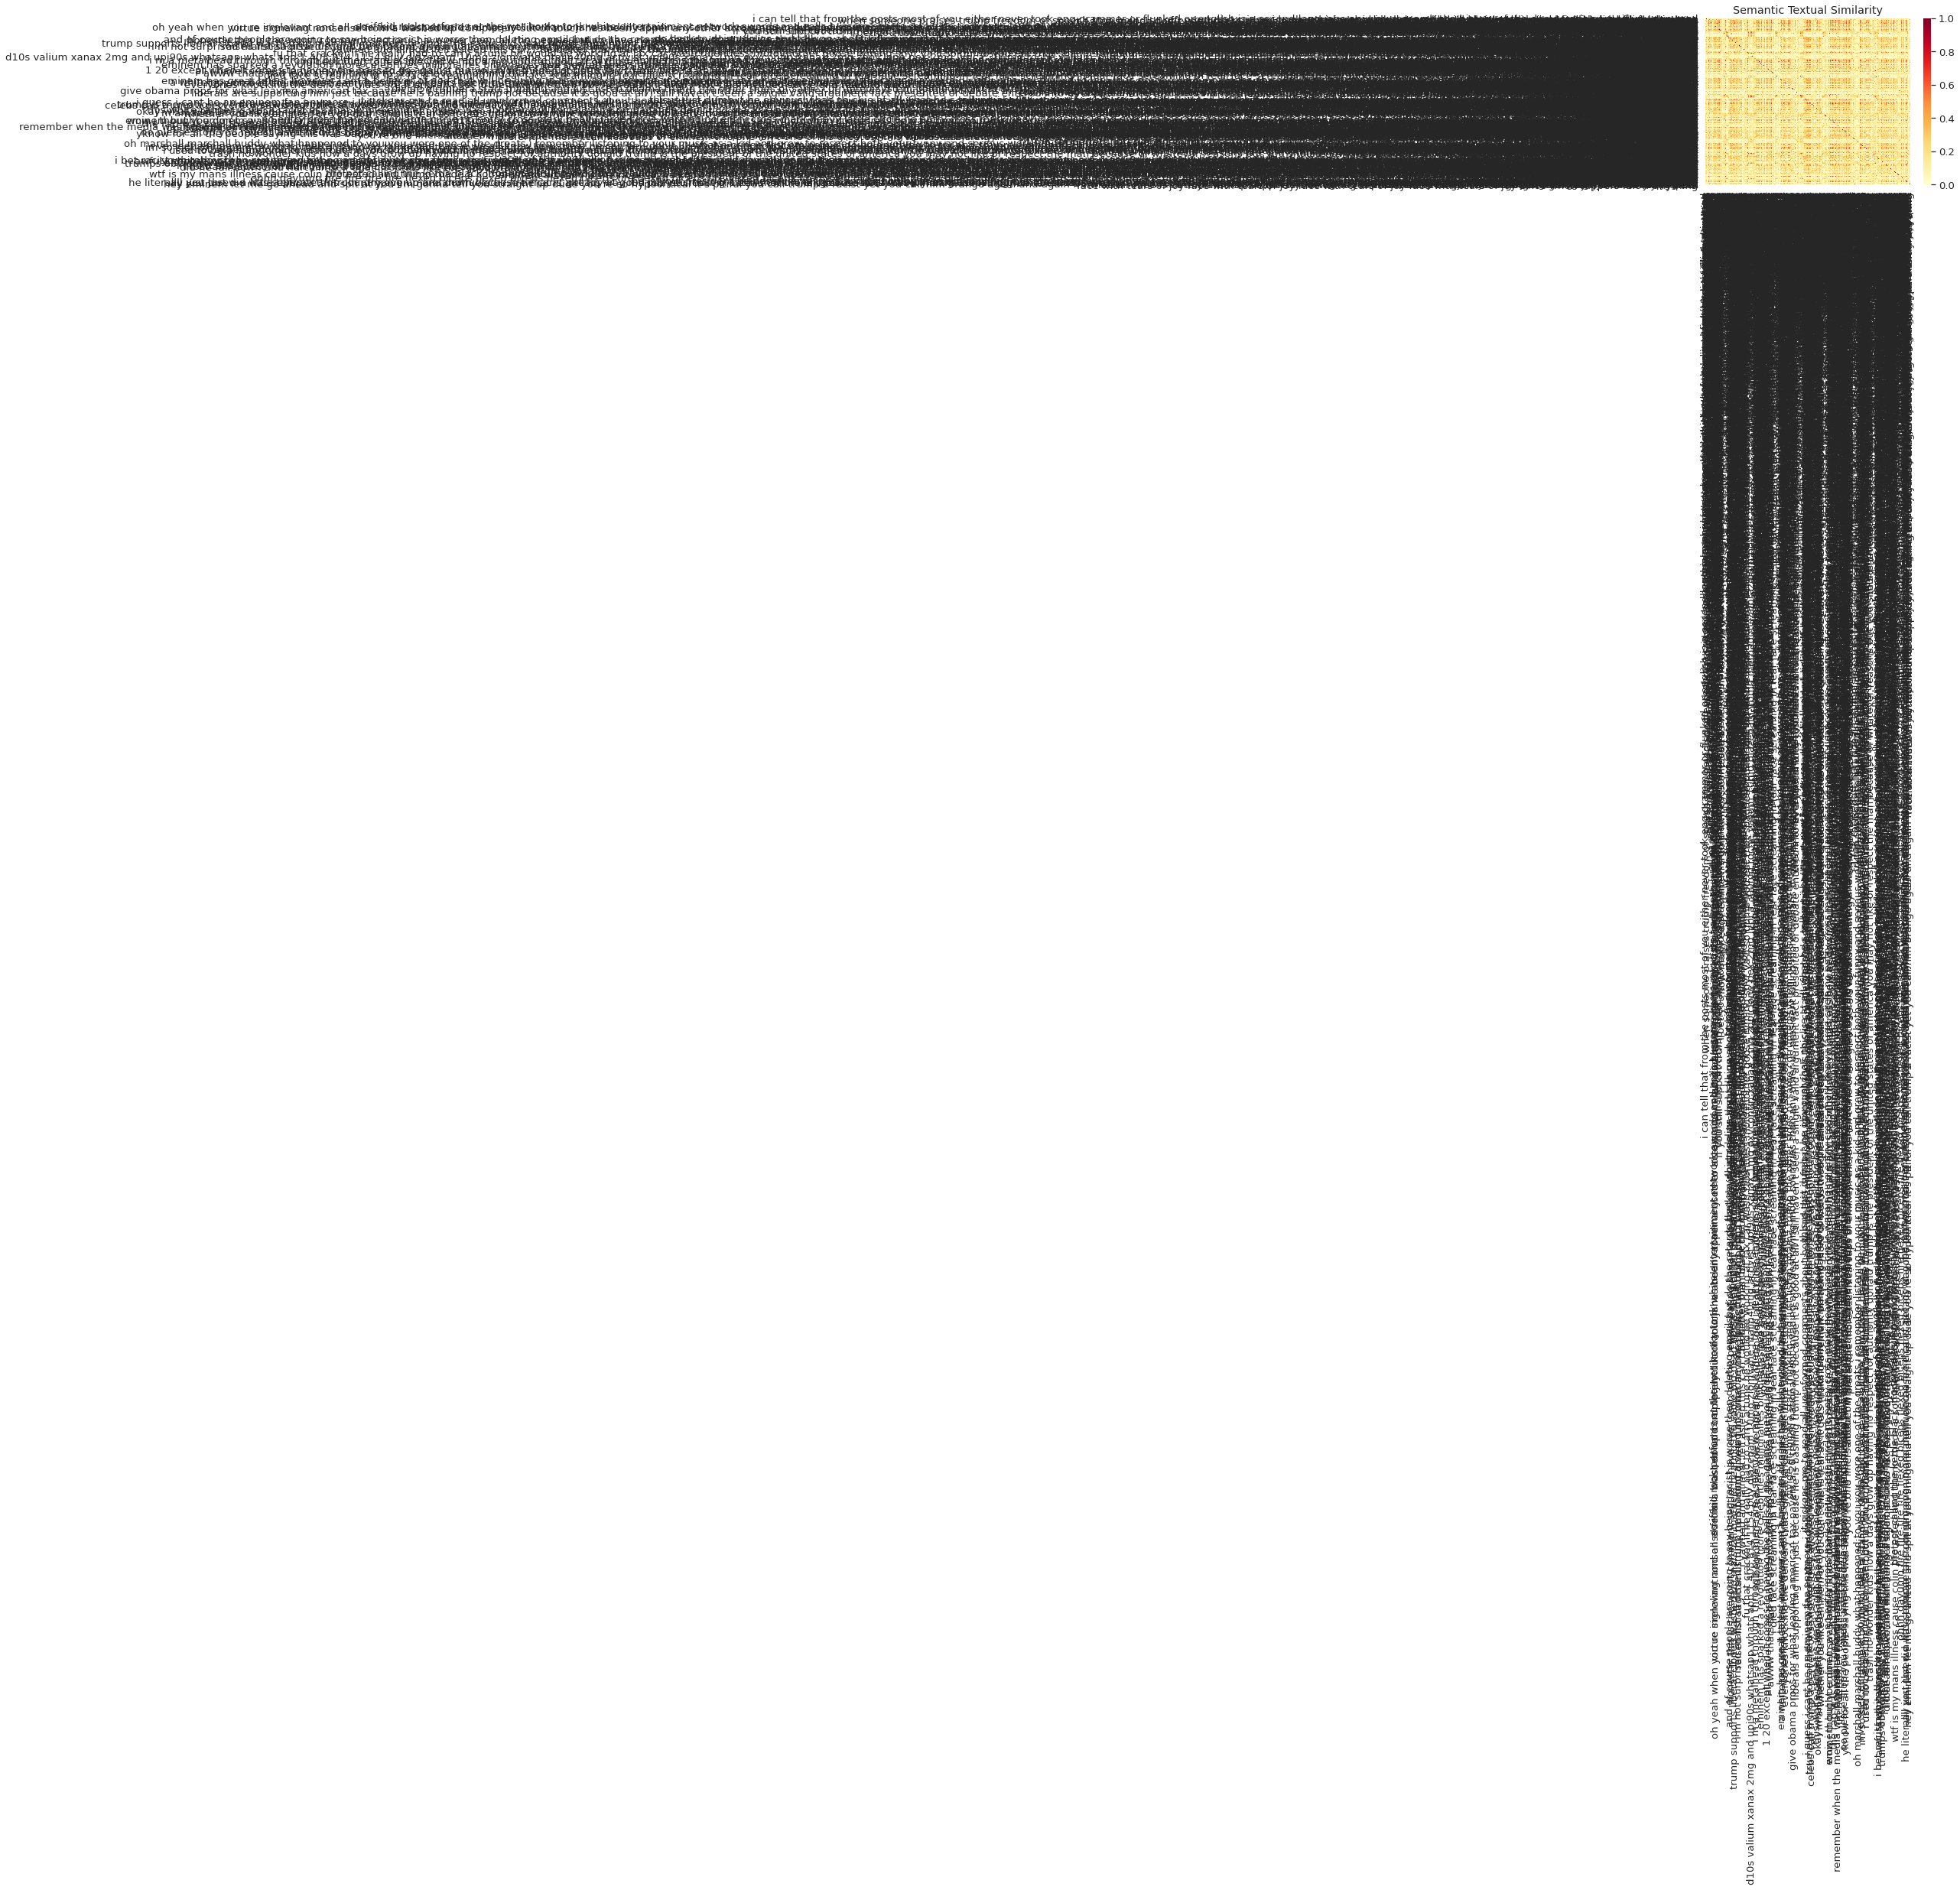

In [ ]:
#run_and_plot(messages)

In [ ]:
from sklearn.manifold 
import TSNE  
tsne_projection = TSNE(n_components=3, perplexity=8.0, learning_rate=100, n_iter=1500)  em_map = tsne_projection.fit_transform(embeddings)